In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN, AgglomerativeClustering
from sklearn.datasets import make_blobs

In [ ]:
x = [4, 5, 10, 4, 3, 11, 14, 6, 10, 12]
y = [21, 19, 24, 17, 16, 25, 24, 22, 21, 21]

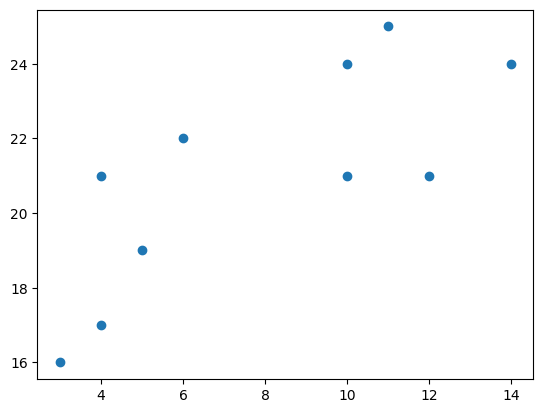

In [ ]:
plt.scatter(x, y)
plt.show()

In [ ]:
data = list(zip(x, y))

In [ ]:
kmean = KMeans(n_clusters = 2)
kmean.fit(data)

KMeans(n_clusters=2)

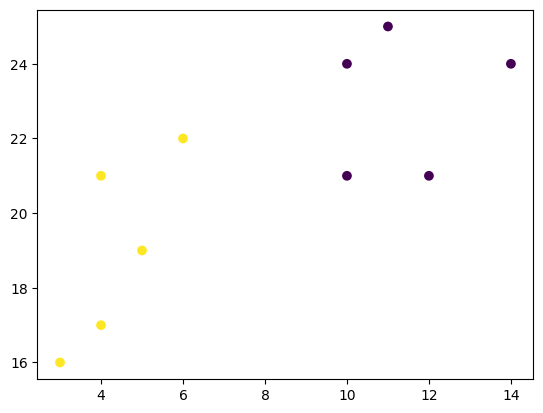

In [ ]:
plt.scatter(x, y,c = kmean.labels_)
plt.show()

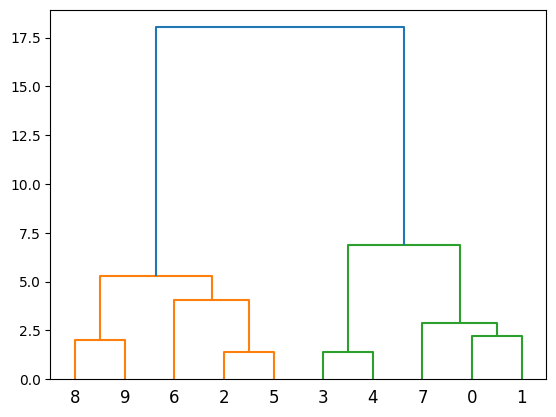

In [ ]:
linkage_data = linkage(data, method = 'ward' , metric = 'euclidean')
dendrogram(linkage_data)
plt.show()

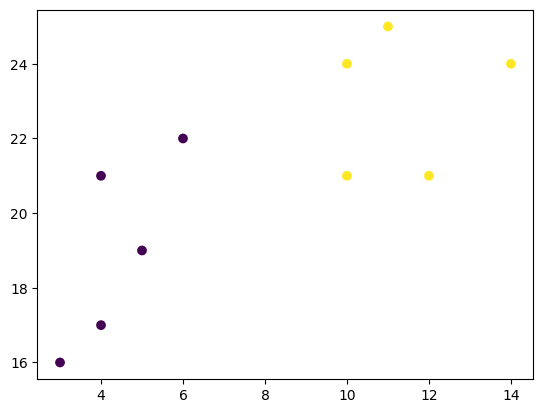

In [ ]:
hierarchical = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
labels = hierarchical.fit_predict(data)
plt.scatter(x, y, c = labels)
plt.show()

In [23]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))

    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    # The probability of a point belonging to its labeled cluster determines the size of its marker
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_index = np.where(labels == k)[0]

        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )

    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"

    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"

    ax.set_title(title)
    plt.tight_layout()

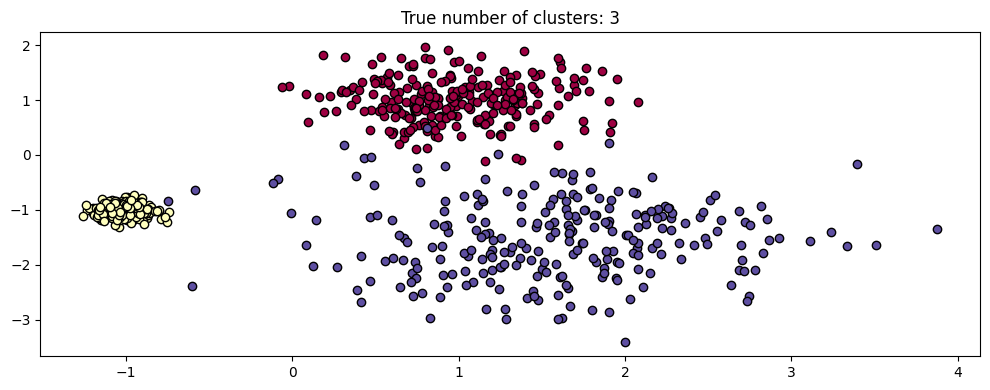

In [24]:
centers = [[1, 1], [-1, -1], [1.5, -1.5]]
x, labels_true = make_blobs(n_samples = 750, centers = centers, cluster_std = [0.4, 0.1, 0.75], random_state = 0)
plot(x, labels = labels_true, ground_truth = True)

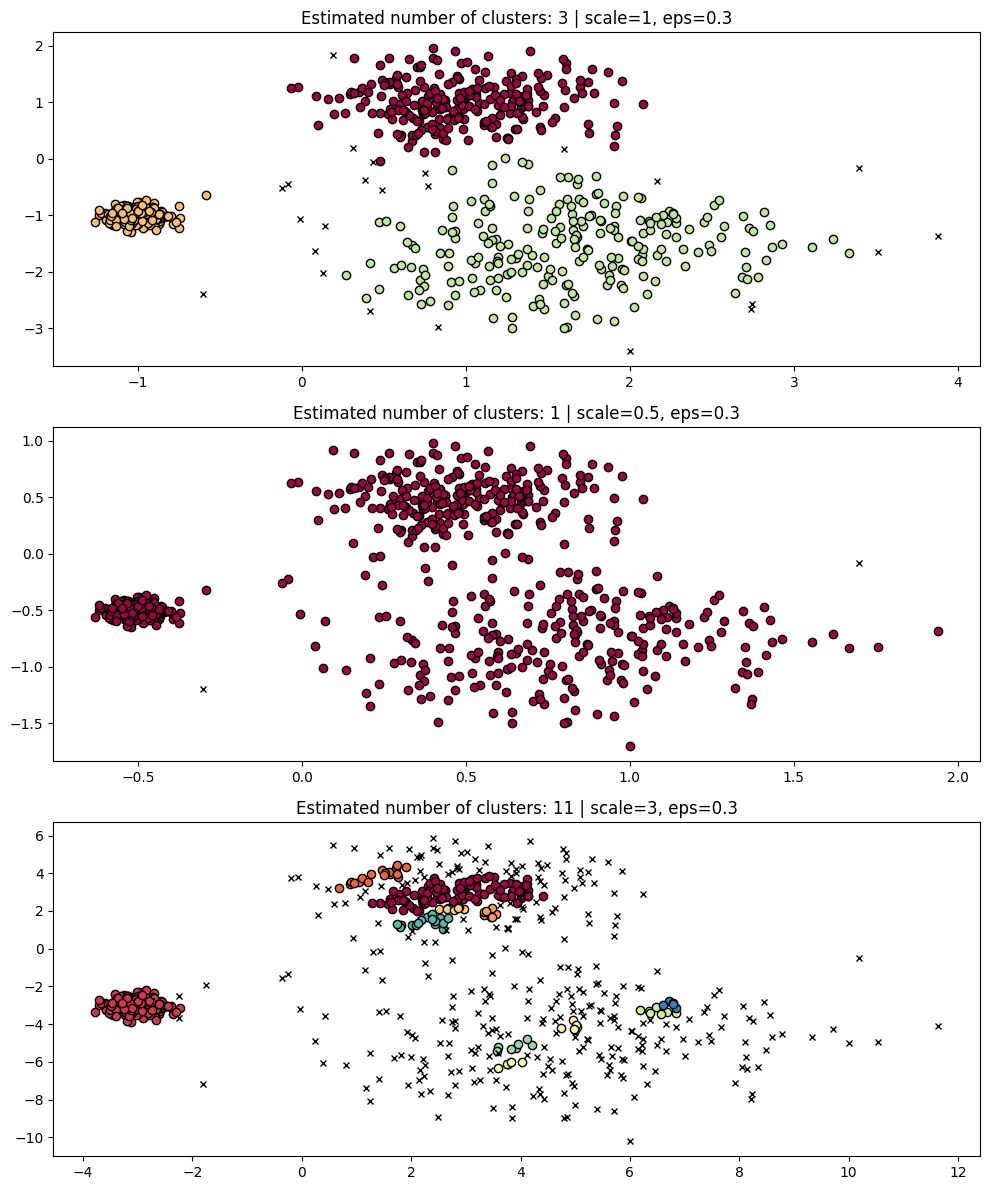

In [25]:
fig, ax = plt.subplots(3, 1, figsize = (10, 12))
dbs = DBSCAN(eps = 0.3)
for idx, scale in enumerate([1, 0.5, 3]):
  dbs.fit(x * scale)
  plot(x * scale,
       dbs.labels_,
       parameters = {"scale": scale, "eps": 0.3},
       ax = ax[idx])

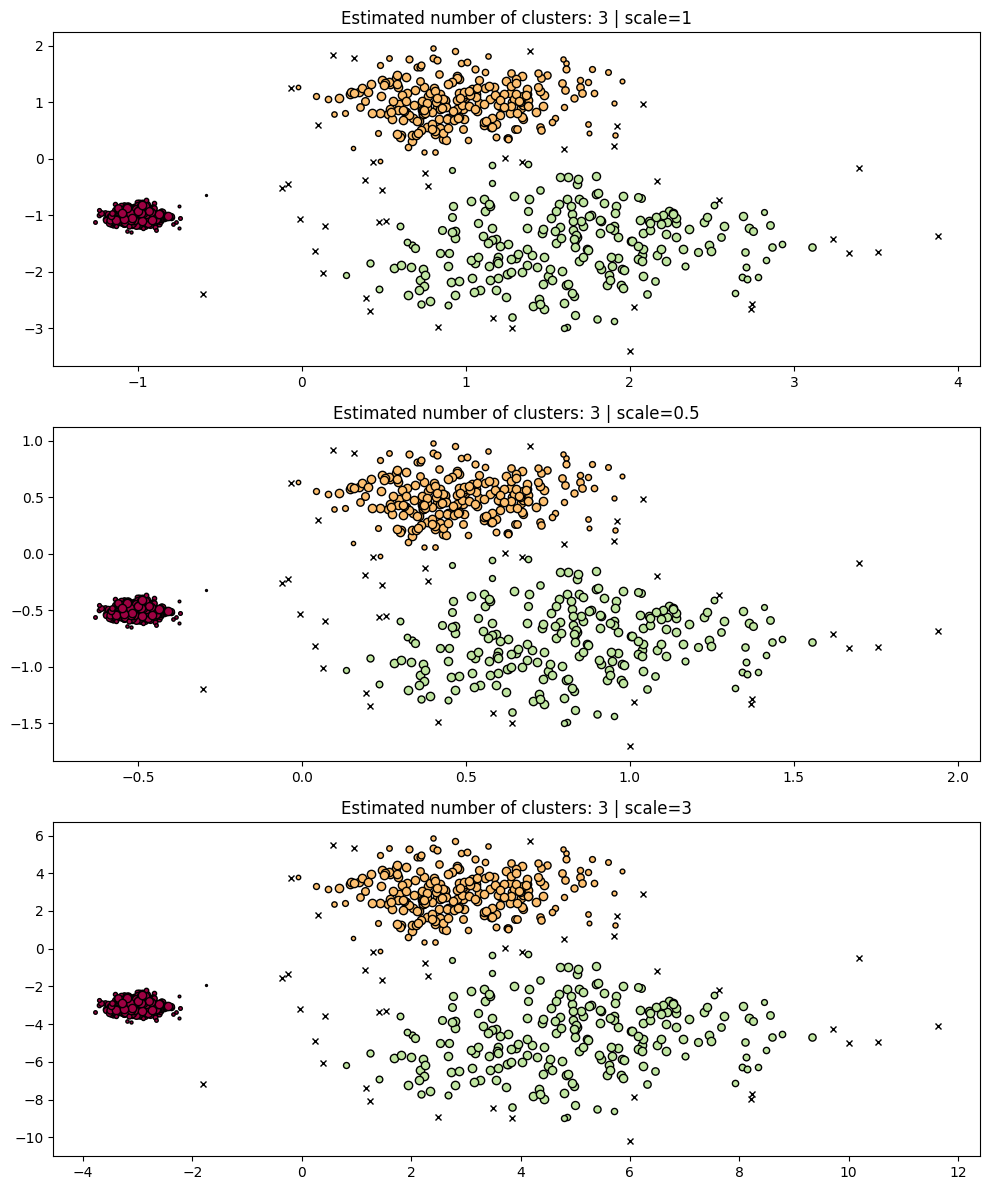

In [27]:
fig, ax = plt.subplots(3, 1, figsize = (10, 12))
hdb = HDBSCAN()
for idx, scale in enumerate([1, 0.5, 3]):
  hdb.fit(x * scale)
  plot(x * scale,
       hdb.labels_,
       hdb.probabilities_,
       ax = ax[idx],
       parameters = {"scale" : scale})

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:323: UserWarning: the number of connected components of the connectivity matrix is 8 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:594: UserWarning: the number of connected components of the connectivity matrix is 8 > 1. Completing it to avoid stopping the tree early.
  connectivity, n_connected_components = _fix_connectivity(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:32

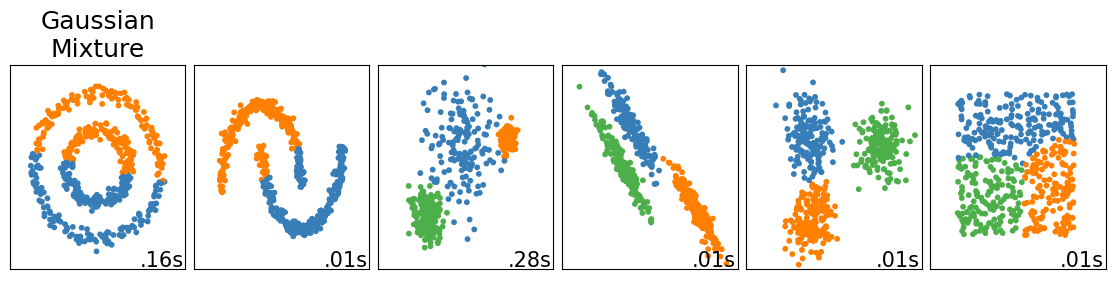

In [33]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

#============
#Generate datasets. We choose the size big enough to see the scalability
#of the algorithms, but not to big to avoid too long running times
#============

n_samples = 500
seed =30
noisy_circles = datasets.make_circles(
    n_samples = n_samples, factor = 0.5, noise = 0.05, random_state = seed
)
noisy_moons = datasets.make_moons(n_samples = n_samples, noise = 0.05, random_state = seed)
blobs = datasets.make_blobs(n_samples = n_samples, random_state = seed)
rng = np.random.RandomState(seed)
no_structure = rng.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples = n_samples, random_state = random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

#blobs with varied variances
varied = datasets.make_blobs(
    n_samples = n_samples, cluster_std=[1.0, 2.5, 0.5], random_state = random_state
)

#==========
# Set up cluster paeameters
#==========
plt.figure(figsize = (9 * 2 + 3, 13))
plt.subplots_adjust(
    left = 0.02, right = 0.98, bottom = 0.001, top = 0.95, wspace = 0.05, hspace = 0.01
)
plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42
}

datasets = [
    (
        noisy_circles,
         {
             "damping": 0.77,
             "preference": -240,
             "quantile": 0.2,
             "n_clusters": 2,
             "min_samples": 7,
             "xi": 0.08,
         }
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
         }
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_sample": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2
        }
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2
        }
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
  #update parameters with dataset-specific values
  params = default_base.copy()
  params.update(algo_params)

  X, y = dataset

  #normalize dataset for easier parameter selection
  X = StandardScaler().fit_transform(X)

  #estimate bandwidth for mean shift
  bandwidth = cluster.estimate_bandwidth(X, quantile = params["quantile"])

  #connectivity matrix for structured Ward
  connectivity = kneighbors_graph(
      X, n_neighbors = params["n_neighbors"], include_self = False
  )

  #make connectivity symmetric
  connectivity = 0.5 * (connectivity + connectivity.T)

  #=========
  #Create cluster objects
  #=========
  ms = cluster.MeanShift(bandwidth = bandwidth, bin_seeding = True)
  two_means = cluster.MiniBatchKMeans(
      n_clusters = params["n_clusters"],
      random_state = params["random_state"]
  )
  ward = cluster.AgglomerativeClustering(
      n_clusters = params["n_clusters"],
      linkage = "ward",
      connectivity = connectivity
  )

  spectral = cluster.SpectralClustering(
      n_clusters = params["n_clusters"],
      eigen_solver = "arpack",
      affinity = "nearest_neighbors",
      random_state = params["random_state"]
  )
  dbscan = cluster.DBSCAN(eps = params["eps"])
  hdbscan = cluster.HDBSCAN(
      min_samples = params["hdbscan_min_samples"],
      min_cluster_size = params["hdbscan_min_cluster_size"],
      allow_single_cluster = params["allow_single_cluster"],
  )
  optics = cluster.OPTICS(
      min_samples = params["min_samples"],
      xi = params["xi"],
      min_cluster_size = params["min_cluster_size"],
  )
  affinity_propagation = cluster.AffinityPropagation(
      damping = params["damping"],
      preference = params["preference"],
      random_state = params["random_state"]
  )
  average_linkage = cluster.AgglomerativeClustering(
      linkage = "average",
      metric = "cityblock",
      n_clusters = params["n_clusters"],
      connectivity = connectivity
  )
  birch = cluster.Birch(n_clusters = params["n_clusters"])
  gmm = mixture.GaussianMixture(
      n_components = params["n_clusters"],
      covariance_type = "full",
      random_state = params["random_state"]
  )

  clustering_algorithms = (
      ("MiniBatch\nKMeans", two_means),
      ("Affinity\nPropagation", affinity_propagation),
      ("MeanShift", ms),
      ("Spectral\nClustering", spectral),
      ("Ward", ward),
      ("Agglomerative\nClustering", average_linkage),
      ("DBSCAN", dbscan),
      ("HDBSCAN", hdbscan),
      ("OPTICS", optics),
      ("BIRCH", birch),
      ("Gaussian\nMixture", gmm),
  )

  for name, algorithm in clustering_algorithms:
    t0 = time.time()

    #catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
      warnings.filterwarnings(
          "ignore",
          message="the number of connected components of the"
          + "connectivity matrix is [0-9]{1,2}"
          + " > 1. Completing it to avoid stopping the tree early.",
      category=UserWarning,
    )
    warnings.filterwarnings(
        "ignore",
        message="Graph is not fully connected, spectral embedding"
        + " may not work as expected. ",
        category = UserWarning,
    )
    algorithm.fit(X)

  t1 = time.time()
  if hasattr(algorithm, "labels_"):
    y_pred = algorithm.labels_.astype(int)
  else :
    y_pred = algorithm.predict(X)

  plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
  if i_dataset == 0:
    plt.title(name, size = 18)

  colors = np.array(
      list(
          islice(
              cycle(
                  [
                    "#377eb8",
                    "#ff7f00",
                    "#4daf4a",
                    "#f781bf",
                    "#a65628",
                    "#984ea3",
                    "#999999",
                    "#e41a1c",
                    "#dede00",
                  ]
              ),
              int(max(y_pred) + 1),
          )
      )
  )
  #add black color for outliers (if any)
  colors = np.append(colors, ["#000000"])
  plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

  plt.xlim(-2.5, 2.5)
  plt.ylim(-2.5, 2.5)
  plt.xticks(())
  plt.yticks(())
  plt.text(
      0.99,
      0.01,
      ("%.2fs" % (t1 - t0)).lstrip("0"),
      transform = plt.gca().transAxes,
      size = 15,
      horizontalalignment = "right",
  )
  plot_num += 1

plt.show()